# Manuscript figure generation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import collections
import seaborn as sns
import os
from pathlib import Path
import glob
import re
from cycler import cycler
import itertools

import fiona
import geopandas as gp
from shapely.geometry import LineString, Point, Polygon

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom


import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent

%matplotlib inline

sns.color_palette()

sns.set_style("white", {"xtick.direction": "in","ytick.direction": "in"})
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors[:6]) 
my_tiel = (0.4, 0.7607843137254902, 0.6470588235294118) # Recycling
my_orange = (0.9882352941176471, 0.5529411764705883, 0.3843137254901961) # Manufacturing
my_purple = (0.5529411764705883, 0.6274509803921569, 0.796078431372549) # 40209
my_pink = (0.9058823529411765, 0.5411764705882353, 0.7647058823529411) #NAICS

cb_pink = '#D81B60'
cb_blue = '#1E88E5'
cb_yellow = '#FFC107'
cb_green = '#004D40'

ibm_blue = '#648FFF'
ibm_purple = '#785EF0'
ibm_pink = '#DC267F'
ibm_orange = '#FE6100'
ibm_yellow = '#FFB000'

NREL colors

In [2]:
# 1 through 4 means dark to light
blue_1 = '#0B5E90'
blue_2 = '#0079C2'
blue_3 = '#00A4E4'
blue_4 = '#5DD2FF'

yellow_1 = '#A16911'
yellow_2 = '#F7A11A'
yellow_3 = '#FFC423'
yellow_4 = '#FFD200'

green_1 = '#3D6321'
green_2 = '#5D9732'
green_3 = '#8CC63F'
green_4 = '#C1EE86'

red_1 = '#6F2D01'
red_2 = '#933C06'
red_3 = '#D9531E'
red_4 = '#FE6523'

grey_1 = '#4B545A'
grey_2 = '#5E6A71'
grey_3 = '#D1D5D8'
grey_4 = '#DEE2E5'

black_1 = '#000000'
black_2 = '#212121'
black_3 = '#282D30'
black_4 = '#3A4246'

### Setup all file scenarios

The files I am going to load are the ones showed in the excel `RELOG_case_builder_io_clean_publication`. This is to know which file correspond to what. 

In [3]:
cwd = os.getcwd()

In [4]:
facility_label = ['Manufacturing', 'Recycling','Manufacturing_cap', 'Recycling_cap']
location_label = ['NAICS', '40209']
factor_label_rec = ['05', '1', '2', '5', '10']
factor_label_man = ['05', '1', '2', '5', '10'] # 0 is 0,5

In [5]:
files_list = []
for fac in facility_label:
    for loc in location_label:
        if fac.startswith('Manufacturing'):
            for fac_man in factor_label_man:
                files_list.append(fac+'_'+loc+'_'+fac_man)
        else:
            for fac_rec in factor_label_rec:
                files_list.append(fac+'_'+loc+'_'+fac_rec) 

In [6]:
facility_label_both = ['Manufacturing', 'Recycling']
location_label = ['BOTH', 'BOTHS']
discount_yn = ['ND', 'D']
discount_perc = ['30']
factor_label = ['1']
 # add the appropiate discount or a list of discounts, the numbers are in %

In [7]:
for faci in facility_label_both:
    for loc in location_label:
        for disc in discount_yn:
            if disc.startswith('ND'):
                for fac in factor_label:
                        files_list.append(faci+'_'+loc+'_'+disc+'_'+fac)
            else:
                for perc in discount_perc:
                    for fac in factor_label:
                        files_list.append(faci+'_'+loc+'_'+disc+'_'+perc+'_'+fac) 

#### Group the files into smaller bins for easier handling

In [8]:
recycling_files = [x for x in files_list if x.startswith('Recycling')]
recycling_files_cap = [x for x in recycling_files if "cap" in x]
recycling_files_cost = [x for x in recycling_files if "cap" not in x]
recycling_files_both_d = [x for x in recycling_files if "BOTH" in x and 'ND' not in x]
recycling_files_both_nd = [x for x in recycling_files if "BOTH" in x and 'ND' in x]


In [9]:
manufacturing_files = [x for x in files_list if x.startswith('Manufacturing')]
manufacturing_files_cap = [x for x in manufacturing_files if "cap" in x]
manufacturing_files_cost = [x for x in manufacturing_files if "cap" not in x]
manufacturing_files_both_d = [x for x in manufacturing_files if "BOTH" in x and 'ND' not in x]
manufacturing_files_both_nd = [x for x in manufacturing_files if "BOTH" in x and 'ND' in x]

#### Dictionary to change year number to actual years

In [10]:
year_list = list(range(2025, 2051, 1))
number_year = list(range(1, 27, 1))
years_dict = dict(zip(number_year,year_list))


#### Load plant files

In [11]:
previous_folder = os.path.normpath(os.getcwd() + os.sep + os.pardir) # Get previous folder from current directory

In [12]:
previous_previous_folder = os.path.normpath(os.getcwd() + os.sep + os.pardir+os.sep+ os.pardir)

##### Load candidate locations

In [13]:
previous_previous_folder

'/Users/hwikoff/Documents/RICE'

In [14]:
candidates_path = glob.glob(os.path.join(previous_previous_folder, '2_data_preparation', 'RELOG_import_data', 'CandidateLocations'))[0]
cl_40209 = pd.read_csv(os.path.join(candidates_path, 'cl_40209_retired_plants.csv')) 
cl_NAICS = pd.read_csv(os.path.join(candidates_path, 'cl_igate_single_loc_filter_naics.csv')) 
cl_both = pd.read_csv(os.path.join(candidates_path, 'cl_naics_40209_together_no_discount.csv')) 
cl_sel_man = pd.read_csv(os.path.join(candidates_path, 'cl_selected_man_naics_40209_together_no_discount.csv')) 
cl_sel_rec = pd.read_csv(os.path.join(candidates_path, 'cl_selected_rec_naics_40209_together_no_discount.csv')) 

In [15]:
def NAICS_or_40209(df):
    location_type = []
    for locations in df['name']:
        if locations[-2:].isupper():
            location_type.append('NAICS')
        else:
            location_type.append('40209')
    df['location type'] = location_type
    return df

In [16]:
NAICS_or_40209(cl_40209)
NAICS_or_40209(cl_NAICS)
NAICS_or_40209(cl_sel_man)
NAICS_or_40209(cl_sel_rec);

In [17]:
print('40209 locations have {} candidates.'.format(len(cl_40209)))
print('NAICS locations have {} candidates.'.format(len(cl_NAICS)))
print('BOTH locations have {} candidates.'.format(len(cl_both)))
print('BOTH SELECTED locations in MANUFACTURING have {} candidates.'.format(len(cl_sel_man)))
print('BOTH SELECTED locations in RECYCLING have {} candidates.'.format(len(cl_sel_rec)))

40209 locations have 268 candidates.
NAICS locations have 309 candidates.
BOTH locations have 577 candidates.
BOTH SELECTED locations in MANUFACTURING have 124 candidates.
BOTH SELECTED locations in RECYCLING have 162 candidates.


In [18]:
cl_sel_man['location type'].value_counts()

location type
NAICS    62
40209    62
Name: count, dtype: int64

In [19]:
cl_sel_rec['location type'].value_counts()

location type
NAICS    81
40209    81
Name: count, dtype: int64

##### Recycling cost

In [20]:
previous_folder

'/Users/hwikoff/Documents/RICE/3_RELOG_simulation'

In [21]:
for files in recycling_files_cost:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))

Recycling_NAICS_05: 91 locations
Recycling_NAICS_1: 81 locations
Recycling_NAICS_2: 81 locations
Recycling_NAICS_5: 81 locations
Recycling_NAICS_10: 81 locations
Recycling_40209_05: 85 locations
Recycling_40209_1: 81 locations
Recycling_40209_2: 81 locations
Recycling_40209_5: 81 locations
Recycling_40209_10: 81 locations
Recycling_BOTH_ND_1: 81 locations
Recycling_BOTH_D_30_1: 81 locations
Recycling_BOTHS_ND_1: 84 locations
Recycling_BOTHS_D_30_1: 81 locations


##### Manufacturing cost

In [22]:
for files in manufacturing_files_cost:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path) 
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))

Manufacturing_NAICS_05: 62 locations
Manufacturing_NAICS_1: 62 locations
Manufacturing_NAICS_2: 62 locations
Manufacturing_NAICS_5: 62 locations
Manufacturing_NAICS_10: 62 locations
Manufacturing_40209_05: 62 locations
Manufacturing_40209_1: 62 locations
Manufacturing_40209_2: 62 locations
Manufacturing_40209_5: 62 locations
Manufacturing_40209_10: 62 locations
Manufacturing_BOTH_ND_1: 62 locations
Manufacturing_BOTH_D_30_1: 62 locations
Manufacturing_BOTHS_ND_1: 62 locations
Manufacturing_BOTHS_D_30_1: 62 locations


##### Recycling capacity

In [23]:
for files in recycling_files_cap:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

Recycling_cap_NAICS_05: 161 locations
Recycling_cap_NAICS_1: 81 locations
Recycling_cap_NAICS_2: 41 locations
Recycling_cap_NAICS_5: 17 locations
Recycling_cap_NAICS_10: 9 locations
Recycling_cap_40209_05: 161 locations
Recycling_cap_40209_1: 81 locations
Recycling_cap_40209_2: 43 locations
Recycling_cap_40209_5: 17 locations
Recycling_cap_40209_10: 9 locations


##### Manufacturing capacity

In [24]:
for files in manufacturing_files_cap:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

Manufacturing_cap_NAICS_05: 124 locations
Manufacturing_cap_NAICS_1: 62 locations
Manufacturing_cap_NAICS_2: 31 locations
Manufacturing_cap_NAICS_5: 13 locations
Manufacturing_cap_NAICS_10: 7 locations
Manufacturing_cap_40209_05: 124 locations
Manufacturing_cap_40209_1: 62 locations
Manufacturing_cap_40209_2: 31 locations
Manufacturing_cap_40209_5: 13 locations
Manufacturing_cap_40209_10: 7 locations


##### Recycling both NO DISCOUNT

In [25]:
for files in recycling_files_both_nd:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

Recycling_BOTH_ND_1: 81 locations
Recycling_BOTHS_ND_1: 84 locations


##### Recycling both DISCOUNT

In [26]:
for files in recycling_files_both_d:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

Recycling_BOTH_D_30_1: 81 locations
Recycling_BOTHS_D_30_1: 81 locations


##### Manufacturing both NO DISCOUNT

In [27]:
for files in manufacturing_files_both_nd:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

Manufacturing_BOTH_ND_1: 62 locations
Manufacturing_BOTHS_ND_1: 62 locations


##### Manufacturing both DISCOUNT

In [28]:
for files in manufacturing_files_both_d:
    testfile_path = glob.glob(os.path.join(previous_folder, 'simulations', files, 'output', 'plants.csv'))[0]
    globals()['%s_plants' % (files)] = pd.read_csv(testfile_path)
    globals()['%s_plants' % (files)] = globals()['%s_plants' % (files)].replace({"year": years_dict})
    print('{}: {} locations'.format(files, len(globals()['%s_plants' % (files)]['location name'].unique())))    

Manufacturing_BOTH_D_30_1: 62 locations
Manufacturing_BOTHS_D_30_1: 62 locations


### Selected locations plot

In [29]:
rec_cap_locs_data = [['Capacity', 'Recycling', 'NAICS', 0.5, 161], 
                     ['Capacity', 'Recycling','NAICS',1, 81], 
                     ['Capacity', 'Recycling','NAICS',2, 41],
                     ['Capacity', 'Recycling','NAICS',5, 17],
                     ['Capacity', 'Recycling','NAICS',10, 9],
                     ['Capacity', 'Recycling', '40209', 0.5, 161], 
                     ['Capacity', 'Recycling','40209',1, 81], 
                     ['Capacity', 'Recycling','40209',2, 43],
                     ['Capacity', 'Recycling','40209',5, 17],
                     ['Capacity', 'Recycling','40209',10, 10],
                     ['Cost', 'Recycling', 'NAICS',0.5, 91], 
                     ['Cost', 'Recycling','NAICS',1, 81], 
                     ['Cost', 'Recycling','NAICS',2, 81],
                     ['Cost', 'Recycling','NAICS',5, 81],
                     ['Cost', 'Recycling','NAICS',10, 81],
                     ['Cost', 'Recycling', '40209',0.5, 85], 
                     ['Cost', 'Recycling','40209',1, 81], 
                     ['Cost', 'Recycling','40209',2, 81],
                     ['Cost', 'Recycling','40209',5, 81],
                     ['Cost', 'Recycling','40209',10, 81],
                     ['Both', 'Recycling', 'All', 1, 81],
                     ['Both', 'Recycling', 'Selected', 1, 84],
                     ['Capacity', 'Manufacturing', 'NAICS',0.5, 124],
                     ['Capacity', 'Manufacturing', 'NAICS',1, 62],
                     ['Capacity', 'Manufacturing', 'NAICS',2, 31],
                      ['Capacity', 'Manufacturing', 'NAICS',5, 13],
                      ['Capacity', 'Manufacturing', 'NAICS',10, 7],
                     ['Capacity', 'Manufacturing', '40209', 0.5, 124],
                     ['Capacity', 'Manufacturing', '40209', 1, 62],
                     ['Capacity', 'Manufacturing', '40209', 2, 31],
                     ['Capacity', 'Manufacturing', '40209', 5, 13],
                     ['Capacity', 'Manufacturing', '40209', 10, 7],
                     # ['Cost', 'Manufacturing', 'NAICS',0.001, 151],
                     ['Cost', 'Manufacturing', 'NAICS',0.5, 62],
                     ['Cost', 'Manufacturing', 'NAICS',1, 62],
                     ['Cost', 'Manufacturing', 'NAICS',2, 62],
                     ['Cost', 'Manufacturing', 'NAICS',5, 62],
                     ['Cost', 'Manufacturing', 'NAICS',10, 62],
                     # ['Cost', 'Manufacturing', '40209',0.001, 143],
                     ['Cost', 'Manufacturing', '40209',0.5, 62],
                     ['Cost', 'Manufacturing', '40209',1, 62],
                     ['Cost', 'Manufacturing', '40209',2, 62],
                     ['Both', 'Manufacturing', 'All', 1, 62], # Changeee
                     ['Both', 'Manufacturing', 'Selected', 1, 62]] 

rec_cap_locs_data_df = pd.DataFrame(rec_cap_locs_data, columns=['Analysis', 'Facility', 'Location group','Factor', 'Selected locations'])

In [30]:
factors = [0.5, 1, 2, 5, 10]

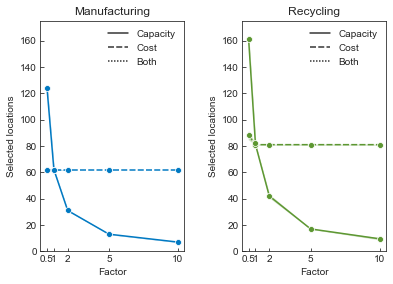

In [31]:
plt.subplot(1, 2, 1)
figure2 = sns.lineplot(x='Factor', y='Selected locations', data=rec_cap_locs_data_df.loc[rec_cap_locs_data_df['Facility'] == 'Manufacturing'], marker='o', style="Analysis", color=blue_2)
figure2.legend(frameon=False)
figure2.set(title='Manufacturing', ylim = (0, 175))
plt.xticks(factors, labels = factors)
plt.savefig(os.path.join(cwd, f"manufacturing_selected.png"), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, f"manufacturing_selected.pdf"), dpi=300);

plt.subplot(1, 2, 2)
figure1 = sns.lineplot(x='Factor', y='Selected locations', data=rec_cap_locs_data_df.loc[rec_cap_locs_data_df['Facility'] == 'Recycling'], marker='o', style="Analysis", color=green_2)
figure1.legend(frameon=False)
figure1.set(title='Recycling', ylim = (0, 175))
plt.xticks(factors, labels = factors)
plt.savefig(os.path.join(cwd, f"recycling_selected.png"), transparent=True, dpi=300);
plt.savefig(os.path.join(cwd, f"recycling_selected.pdf"), dpi=300);

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

### Map plots

NAICS locations have two capital letters as the state indicator. I will use it to identify whether a location is NAICS or 40209

In [32]:
both_total_NAICS = 309
both_total_40209 = 268

Function to highlight the selected locations without repeats and identify locations as NAICS or 40209.

In [33]:
def get_unique_and_sort(df):
    location_type = []
    unique_sorted_df = df.loc[df['year'] == 2025].reset_index()
    for locations in unique_sorted_df['location name']:
        if locations[-2:].isupper():
            location_type.append('NAICS')
        else:
            location_type.append('40209')
    unique_sorted_df['location type'] = location_type
    return unique_sorted_df

Function to generate a map with the selected locations separating NAICS from 40209.

In [34]:
def cl_naics_40209_map(df, df2, title):
    fig = plt.figure(figsize=(10,6))

    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(),
                      frameon=False)
    ax.patch.set_visible(False)

    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

    states_shp = os.path.join('resources', 'ne_110m_admin_1_states_provinces_lakes' ,'ne_110m_admin_1_states_provinces_lakes.shp')
    ax.set_title(title)

    def colorize_state(geometry):
        facecolor = (0.9375, 0.9375, 0.859375)
        return {'facecolor': facecolor, 'edgecolor': 'white'}

    ax.add_geometries(
        shpreader.Reader(states_shp).geometries(),
        ccrs.PlateCarree(),
        styler=colorize_state,
        alpha=0.9,
        zorder=1)
    location_colors = {'NAICS':ibm_purple, '40209':ibm_pink}
    ax.scatter(
        x=df['longitude (deg)'],
        y=df['latitude (deg)'],
        s=40,
        c=df['location type'].map(location_colors),
        alpha=0.7,
        zorder = 2,
        transform=ccrs.PlateCarree()
    )
    ax.scatter(
        x=df2['longitude (deg)'],
        y=df2['latitude (deg)'],
        #color="red",
        s=40,
        c=df2['location type'].map(location_colors),
        alpha=0.7,
        zorder = 2,
        transform=ccrs.PlateCarree()
    )
    col_NAICS = Line2D([], [], color="white", marker='o', markerfacecolor=ibm_purple) 
    col_40209 =  Line2D([], [], color="white", marker='o', markerfacecolor=ibm_pink) 
    labels = ['NAICS locations: {}'.format(df2['location type'].value_counts()['NAICS']),
              '40209 locations: {}'.format(df['location type'].value_counts()['40209'])]
    ax.legend([col_NAICS, col_40209], labels,
              loc='lower left', bbox_to_anchor=(0.2, 0.1), frameon=False)

    return plt.show()


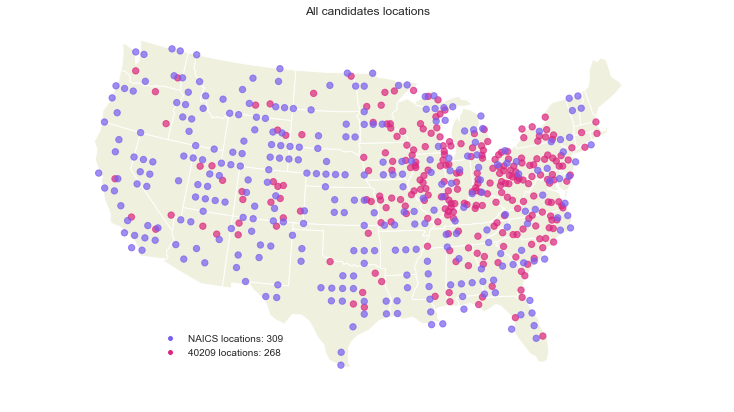

In [35]:
cl_naics_40209_map(cl_40209,cl_NAICS, 'All candidates locations')

In [36]:
def naics_40209_map(df, title):
    df = get_unique_and_sort(df)
    fig = plt.figure(figsize=(10,6))

    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(),
                      frameon=False)
    ax.patch.set_visible(False)

    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

    states_shp = os.path.join('resources', 'ne_110m_admin_1_states_provinces_lakes' ,'ne_110m_admin_1_states_provinces_lakes.shp')
    ax.set_title(title)

    def colorize_state(geometry):
        facecolor = (0.9375, 0.9375, 0.859375)
        return {'facecolor': facecolor, 'edgecolor': 'white'}

    ax.add_geometries(
        shpreader.Reader(states_shp).geometries(),
        ccrs.PlateCarree(),
        styler=colorize_state,
        zorder=1,
        alpha=0.9)
    location_colors = {'NAICS':ibm_purple, '40209':ibm_pink}
    ax.scatter(
        x=df['longitude (deg)'],
        y=df['latitude (deg)'],
        #color="red",
        s=40,
        c=df['location type'].map(location_colors),
        alpha=0.5,
        zorder = 2,
        transform=ccrs.PlateCarree()
    )
    col_NAICS = Line2D([], [], color="white", marker='o', markerfacecolor=ibm_purple) 
    col_40209 =  Line2D([], [], color="white", marker='o', markerfacecolor=ibm_pink) 
    labels = ['NAICS locations: {}'.format(df['location type'].value_counts()['NAICS']),
              '40209 locations: {}'.format(df['location type'].value_counts()['40209'])]
    ax.legend([col_NAICS, col_40209], labels,
              loc='lower left', bbox_to_anchor=(0.2, 0.1), frameon=False)

    return plt.show()


#### Plot for Manufacturing and Recycling, all and selected, NO discount

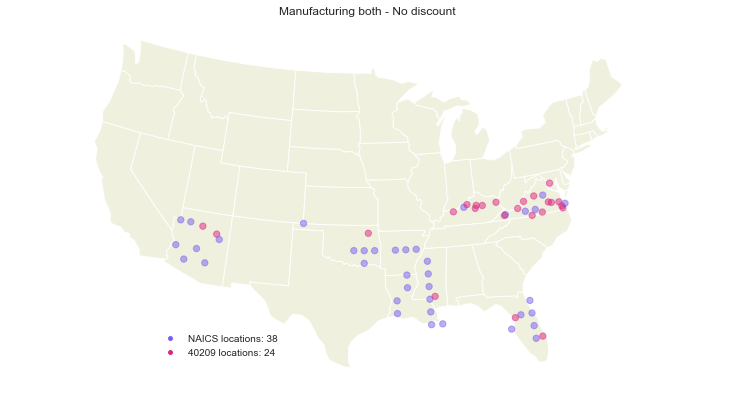

In [37]:
naics_40209_map(Manufacturing_BOTH_ND_1_plants, 'Manufacturing both - No discount')

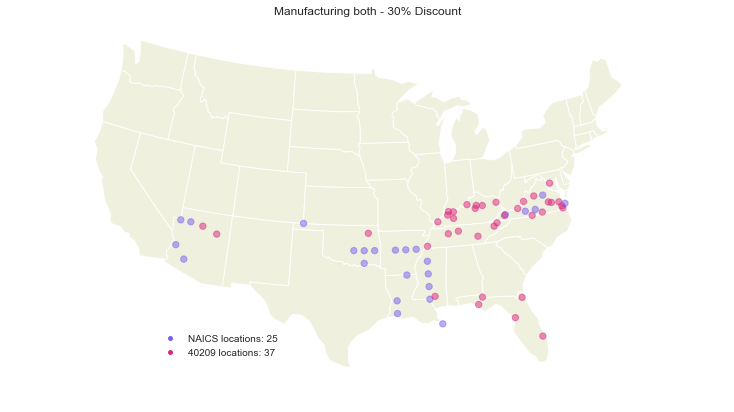

In [38]:
naics_40209_map(Manufacturing_BOTH_D_30_1_plants, 'Manufacturing both - 30% Discount')

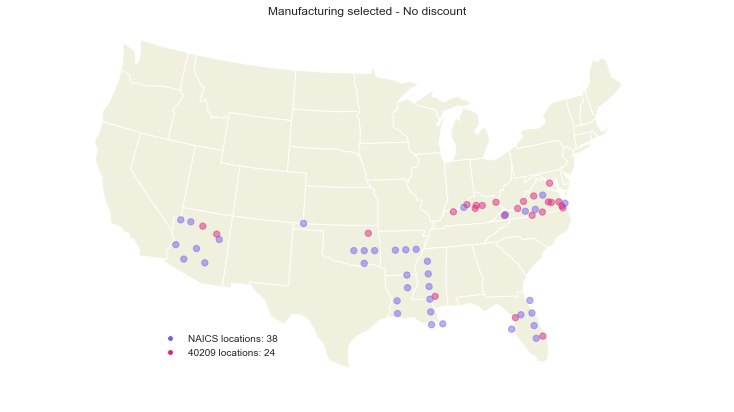

In [39]:
naics_40209_map(Manufacturing_BOTHS_ND_1_plants, 'Manufacturing selected - No discount')

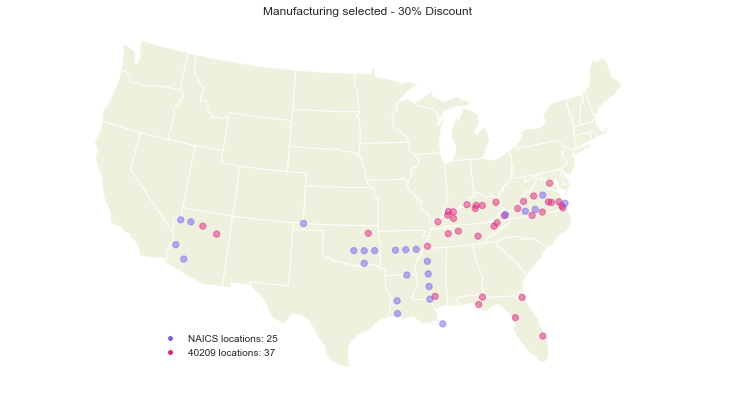

In [40]:
naics_40209_map(Manufacturing_BOTHS_D_30_1_plants, 'Manufacturing selected - 30% Discount')

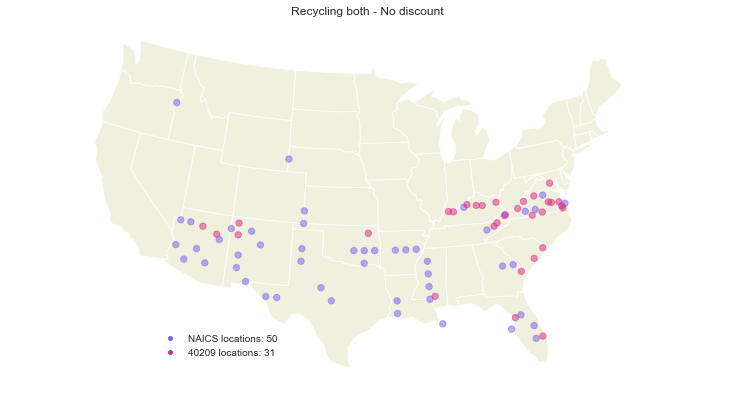

In [41]:
naics_40209_map(Recycling_BOTH_ND_1_plants, 'Recycling both - No discount')

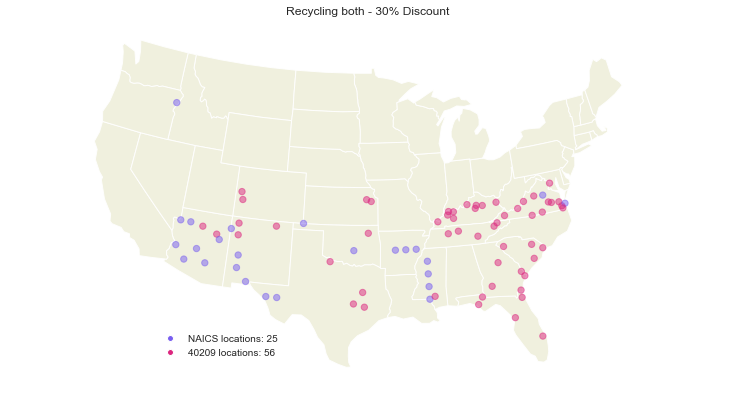

In [42]:
naics_40209_map(Recycling_BOTH_D_30_1_plants, 'Recycling both - 30% Discount')

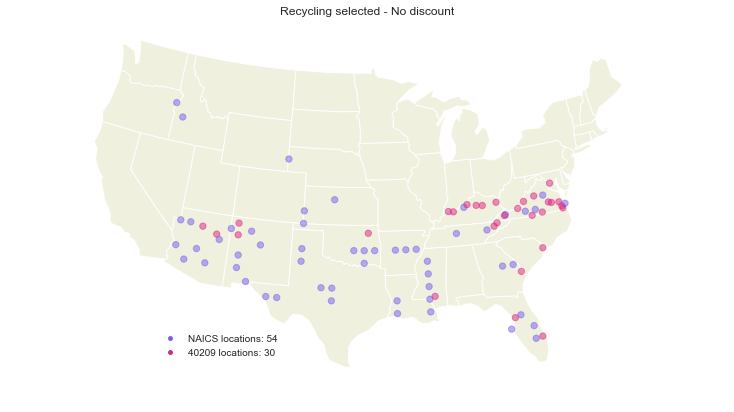

In [43]:
naics_40209_map(Recycling_BOTHS_ND_1_plants, 'Recycling selected - No discount')

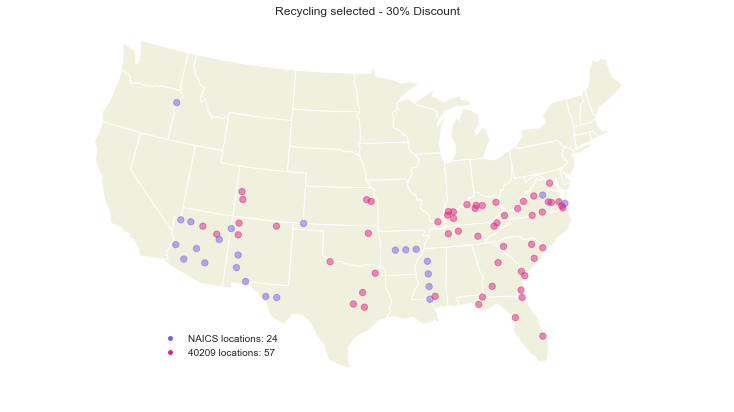

In [44]:
naics_40209_map(Recycling_BOTHS_D_30_1_plants, 'Recycling selected - 30% Discount')

### Heatmapping

In [45]:
previous_previous_folder

'/Users/hwikoff/Documents/RICE'

In [46]:
ia_man_path = os.path.join(previous_previous_folder, '2_data_preparation', 'RELOG_import_data', 'Manufacturing', 'Method1', 'pv_Modules_ia.csv')
ia_rec_path = os.path.join(previous_previous_folder, '2_data_preparation', 'RELOG_import_data', 'Recycling', 'Method1', 'pv_Modules_ia.csv')

In [47]:
ia_man = pd.read_csv(ia_man_path)
ia_rec = pd.read_csv(ia_rec_path)

Let's add states columns so we can put the amounts in bins based on state.

In [48]:
from geopy.geocoders import Nominatim
from geopy.point import Point
# initialize Nominatim API
geolocator = Nominatim(user_agent="myGeocoder")


In [49]:
def city_state_country(row):
    # I map latitude and longitude with actual names of those places.
    coord = f"{row['latitude (deg)']}, {row['longitude (deg)']}"
    location = geolocator.reverse(coord, exactly_one=True)
    address = location.raw['address']
    # city = address.get('city', '')
    # county = address.get('county', '')
    state = address.get('state', '')
    # country = address.get('country', '')
    # county_state = address.get('county', 'state')
    #row['city'] = city
    #row['county'] = county
    row['state'] = state
    #row['country'] = country
    #row['location'] = county_state
    return row

In [50]:
ia_man = ia_man.apply(city_state_country, axis=1)

In [51]:
ia_rec = ia_rec.apply(city_state_country, axis=1)

Group amounts by state.

In [52]:
ia_man_cum = ia_man.groupby(by="state").sum()
ia_rec_cum = ia_rec.groupby(by="state").sum()

Change amount column names for years.

In [53]:
years_list = np.arange(2025, 2051, 1)
years_list = years_list.tolist()

In [54]:
list_amounts = []
for count in range(26):
    list_amounts.append('amount ' + str(count+1))

Dictionary creation to substitute column names (amount # --> year number)

In [55]:
keys = list_amounts
values = years_list
 
# using naive method
# to convert lists to dictionary
dicts = dict(zip(list_amounts, years_list))

Run this one once.

In [56]:
ia_man_cum.rename(columns=dicts, inplace=True)
ia_rec_cum.rename(columns=dicts, inplace=True);

In [57]:
ia_man_cum.reset_index(inplace=True)
ia_rec_cum.reset_index(inplace=True);

Fix Conneticut, for some reason it does not write it as a state.

In [58]:
ia_man_cum['state'][0] = 'Conneticut'
ia_rec_cum['state'][0] = 'Conneticut';

/var/folders/sd/qp9_zxj10w90p1zh00g90zsx5pys5b/T/ipykernel_21010/194581938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ia_man_cum['state'][0] = 'Conneticut'
/var/folders/sd/qp9_zxj10w90p1zh00g90zsx5pys5b/T/ipykernel_21010/194581938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ia_rec_cum['state'][0] = 'Conneticut';


In [59]:
ia_man_cum.sort_values(by=['state'], inplace=True)
ia_man_cum.sort_values(by=['state'], inplace=True)


In [60]:
ia_man_cum['Total'] = ia_man_cum[year_list].sum(axis=1)

In [61]:
ia_rec_cum['Total'] = ia_rec_cum[year_list].sum(axis=1)

#### Heatmap for solar 

Make a dictionary of {state:Total}

In [62]:
dicts_heatsolar = dict(zip(ia_man_cum['state'], ia_man_cum['Total']))

In [63]:
map_shape_file = os.path.join('resources', 'ne_110m_admin_1_states_provinces_lakes' ,'ne_110m_admin_1_states_provinces_lakes.shp')

In [146]:
import geopandas

In [173]:
usa = geopandas.read_file(map_shape_file)  
usa = df.to_crs("ESRI:102003")
usa['values'] = usa['name'].map(dicts_heatsolar)

TypeError: set_ticklabels() takes 2 positional arguments but 3 were given

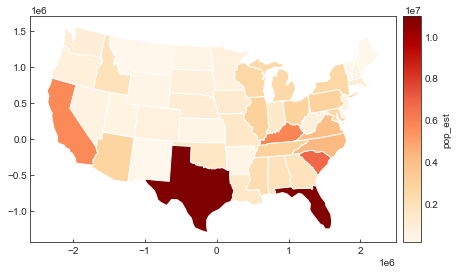

In [237]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# for demo purposes, use the builtin data

maxv, minv = ia_man_cum['Total'].max(), ia_man_cum['Total'].min()

fig, ax = plt.subplots(figsize=(7,6))
divider = make_axes_locatable(ax)

# create `cax` for the colorbar
cax = divider.append_axes("right", size="5%", pad=0.1)

# plot the geodataframe specifying the axes `ax` and `cax` 
usa.plot(column="values", cmap='OrRd', legend=True, \
            vmin=minv, vmax=maxv, ax=ax, cax=cax)

# manipulate the colorbar `cax`
cax.set_ylabel('pop_est', rotation=90)
# set `fontsize` on the colorbar `cax`
cax.set_yticklabels(np.linspace(minv, maxv, 10, dtype=np.dtype(np.uint64)), {'fontsize': 8})

plt.show()


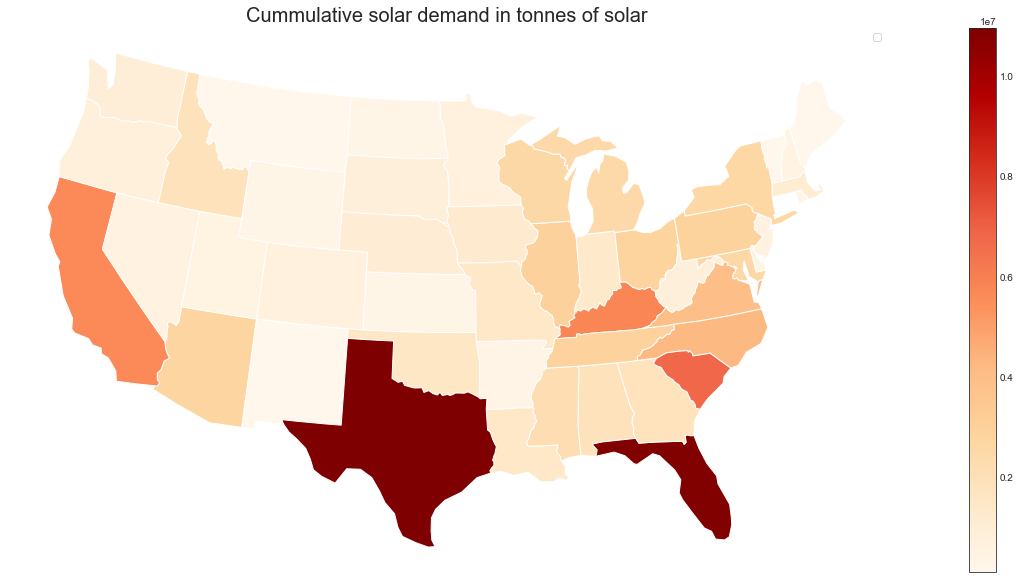

In [251]:

fig, ax = plt.subplots(figsize=(30,10))

#im = usa.plot(ax=ax, column='values', legend=True, cmap='OrRd', norm=mcolors.LogNorm(vmin=ia_man_cum['Total'].min(), vmax=ia_man_cum['Total'].max()))
im = usa.plot(ax=ax, column='values', legend=True, cmap='OrRd')
ax.set_title('Cummulative solar demand in tonnes of solar', fontsize=20)
ax.set_axis_off()

ax.legend('pop_est')
plt.show();


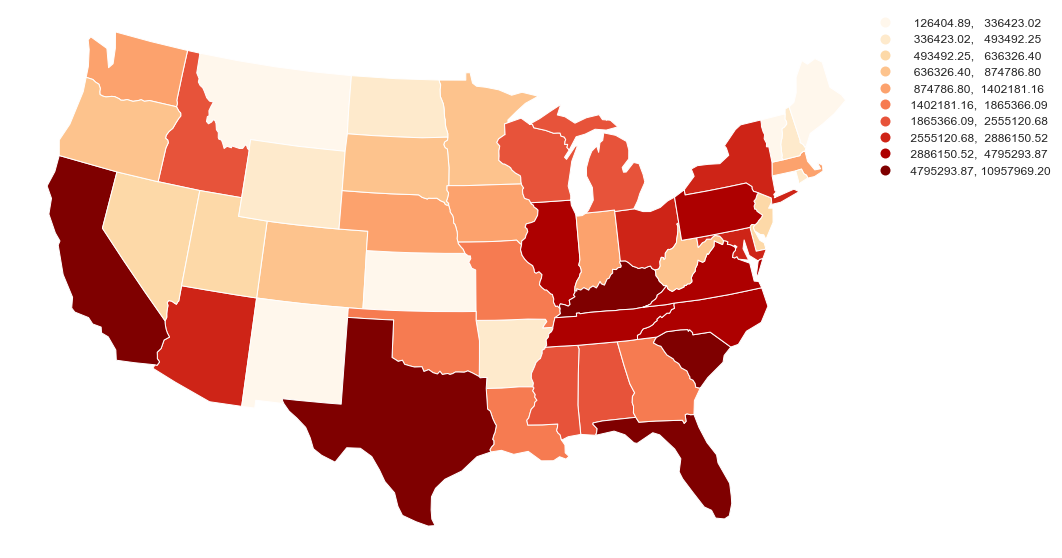

In [271]:
fig, ax = plt.subplots(figsize=(30,10))
usa.plot(ax=ax,column="values", scheme="quantiles", k=10, cmap="OrRd", edgecolor="white", legend=True, 
    legend_kwds={'loc':'upper right', 
                        'bbox_to_anchor':(1.2, 1), 
                        'markerscale':1, 
                        'title_fontsize':'medium', 
                        'fontsize':'large',
                        'frameon':False}, 
)
ax.set_axis_off()